In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from networkx.algorithms import bipartite

%matplotlib inline

In [113]:
# read in the speed dating data
raw = pd.read_csv('./speed_dating.csv') # CHANGE THIS TO YOUR PARTICULAR FILE PATH
df = raw; # temporary

In [50]:
raw.columns.values

array(['iid', 'id', 'gender', 'idg', 'condtn', 'wave', 'round', 'position',
       'positin1', 'order', 'partner', 'pid', 'match', 'int_corr',
       'samerace', 'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int',
       'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o', 'sinc_o',
       'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o',
       'age', 'field', 'field_cd', 'undergra', 'mn_sat', 'tuition', 'race',
       'imprace', 'imprelig', 'from', 'zipcode', 'income', 'goal', 'date',
       'go_out', 'career', 'career_c', 'sports', 'tvsports', 'exercise',
       'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing',
       'reading', 'tv', 'theater', 'movies', 'concerts', 'music',
       'shopping', 'yoga', 'exphappy', 'expnum', 'attr1_1', 'sinc1_1',
       'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr4_1', 'sinc4_1',
       'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1', 'attr2_1', 'sinc2_1',
       'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1', 'si

In [71]:
# feature engineering
age_diff = abs(raw['age'] - raw['age_o']); age_diff = age_diff.rename('age_diff')
avg_attr = pd.Series(name='avg_attr'); avg_sinc = pd.Series(name='avg_sinc'); avg_int = pd.Series(name='avg_int')
avg_fun = pd.Series(name='avg_fun'); avg_amb = pd.Series(name='avg_amb'); avg_shar = pd.Series(name='avg_shar'); 
avg_like = pd.Series(name='avg_like'); avg_prob = pd.Series(name='avg_prob');
for i,r in raw.iterrows(): # FIGURE OUT A BETTER WAY TO DO THIS
    iid = r['iid']
    avg_attr = avg_attr.set_value(i,raw[raw['iid']==iid]['attr_o'].mean())
    avg_sinc = avg_sinc.set_value(i,raw[raw['iid']==iid]['sinc_o'].mean())
    avg_int = avg_int.set_value(i,raw[raw['iid']==iid]['intel_o'].mean())
    avg_amb = avg_amb.set_value(i,raw[raw['iid']==iid]['amb_o'].mean())
    avg_shar = avg_shar.set_value(i,raw[raw['iid']==iid]['shar_o'].mean())
    avg_like = avg_like.set_value(i,raw[raw['iid']==iid]['like_o'].mean())
    avg_prob = avg_prob.set_value(i,raw[raw['iid']==iid]['prob_o'].mean())


In [72]:
# clean up data frame
# TODO: deal with NaNs
# may want to create variables off of: age, race, from, dec/dec_o, like/like_o, prob/prob_o
#   various attribute ratings for the various categories at each time step

# create new data frame
df = raw[['iid','gender','condtn','wave','pid','match','int_corr','samerace','field_cd','career_c','dec','dec_o',
         'like','like_o','prob','prob_o']]
df = pd.concat([df, age_diff, avg_attr, avg_sinc, avg_int, avg_fun, avg_amb, avg_shar, avg_like, avg_prob],axis=1)

In [79]:
# Describe the new data frame

df.head()
#df.describe()
#df['colname'].value_counts()

iid  gender  condtn  wave    pid  match  int_corr  samerace  field_cd  \
8373  552       1       2    21  526.0      0      0.64         0      18.0   
8374  552       1       2    21  527.0      0      0.71         0      18.0   
8375  552       1       2    21  528.0      0     -0.46         0      18.0   
8376  552       1       2    21  529.0      0      0.62         0      18.0   
8377  552       1       2    21  530.0      0      0.01         0      18.0   

      career_c  age_diff  avg_attr  avg_sinc   avg_int  avg_fun  avg_amb  \
8373      15.0       1.0       7.3      5.85  6.157895      NaN     6.15   
8374      15.0       1.0       7.3      5.85  6.157895      NaN     6.15   
8375      15.0       4.0       7.3      5.85  6.157895      NaN     6.15   
8376      15.0       3.0       7.3      5.85  6.157895      NaN     6.15   
8377      15.0       3.0       7.3      5.85  6.157895      NaN     6.15   

      avg_shar  avg_like  avg_prob  
8373       5.0       5.9     3.775  
8374       5.0       5.9     3.775  
8375       5.0       5.9     3.775  
8376       5.0       5.9     3.775  
8377       5.0       5.9     3.775

In [64]:
# node features of import
node_feat = ['gender', 'field_cd', 'career_c']

# create graphs for each wave
waves = df['wave'].unique()
graphs = list()

# graphs for each wave of matches
for w in waves:
    dta = df.loc[df['wave'] == w]
    # TODO: figure out what other edge attributes to include
    G = nx.from_pandas_dataframe(dta,'iid','pid',edge_attr=['match','samerace','int_corr'])
    
    # set node attributes
    # TODO: figure out what other node attributes to include
    for a in node_feat:
        feat = dta[['iid',a]]
        feat = feat.set_index('iid').T.to_dict('records')[0] # convert to dictionary
        nx.set_node_attributes(G,a,feat)
    
    G = nx.convert_node_labels_to_integers(G,first_label=1)
    graphs.append(G)

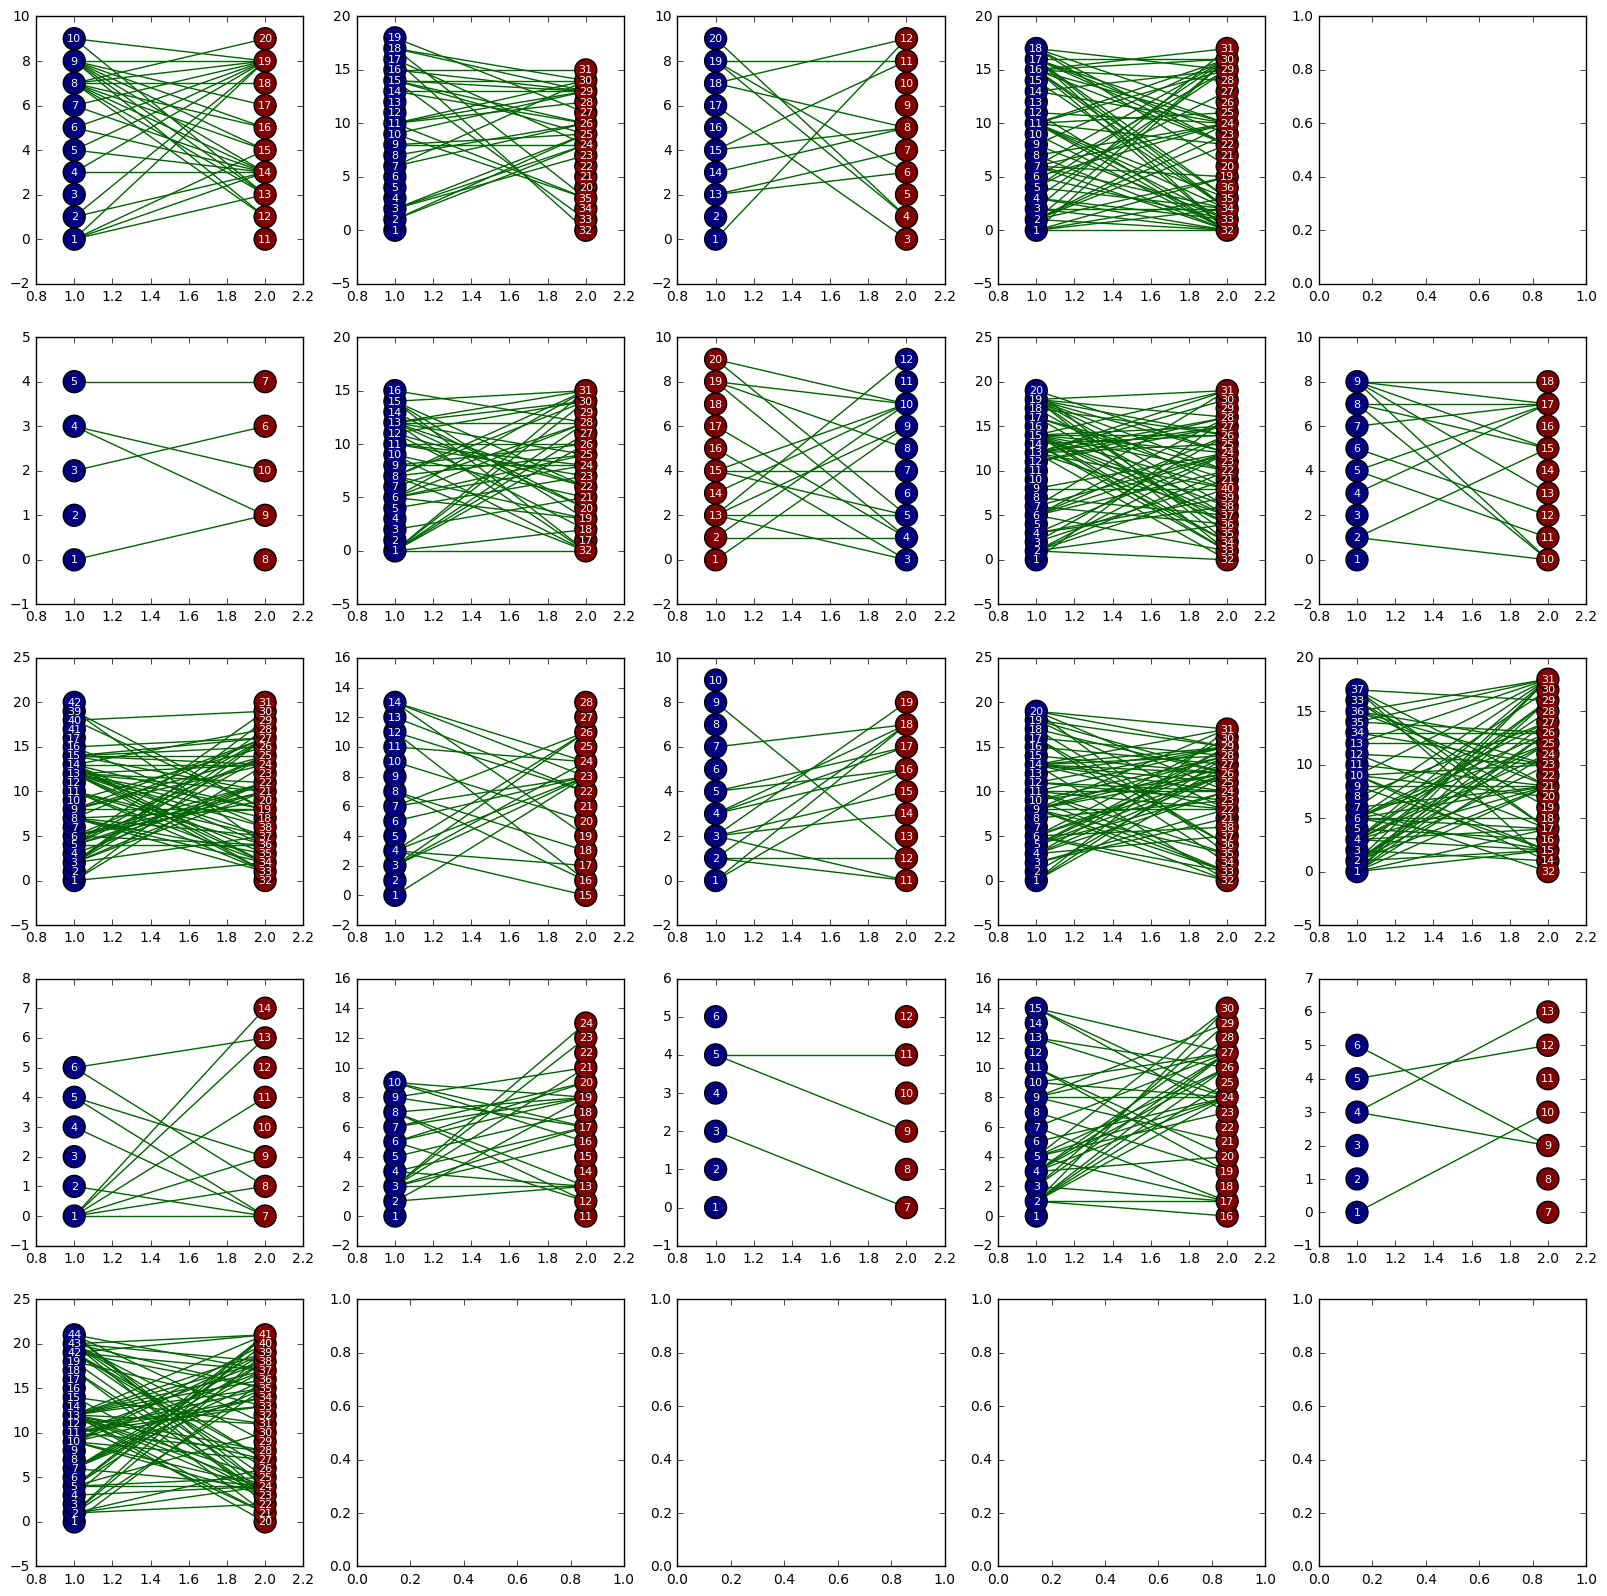

In [35]:
# Visualize the actual networks
f, axs = plt.subplots(5,5,figsize=(20,20))

for i,_ in enumerate(graphs):
    G = graphs[i]
    if i == 4: continue # causing an error bc labels are off in data

    # draw as bipartite graph
    X,Y = bipartite.sets(G) # X=females,Y=males
    pos = dict()
    pos.update( (n, (1, j)) for j, n in enumerate(X) ) # put nodes from X at x=1
    pos.update( (n, (2, j)) for j, n in enumerate(Y) ) # put nodes from Y at x=2

    # draw only edges where the two people matched
    matches = list()
    for u,v in G.edges():
        if G[u][v]['match'] == 1:
            matches.append( (u,v) )

    # get specified feature for each node
    feats = nx.get_node_attributes(G,'gender').values() # blue=female, red=male

    plt.subplot(5,5,i+1)
    nx.draw_networkx_nodes(G,pos,node_color=feats,node_size=250)
    nx.draw_networkx_labels(G,pos,font_color='white',font_size=8)
    nx.draw_networkx_edges(G,pos,edgelist=matches,edge_color='darkgreen')
    
plt.show() # display all the plots

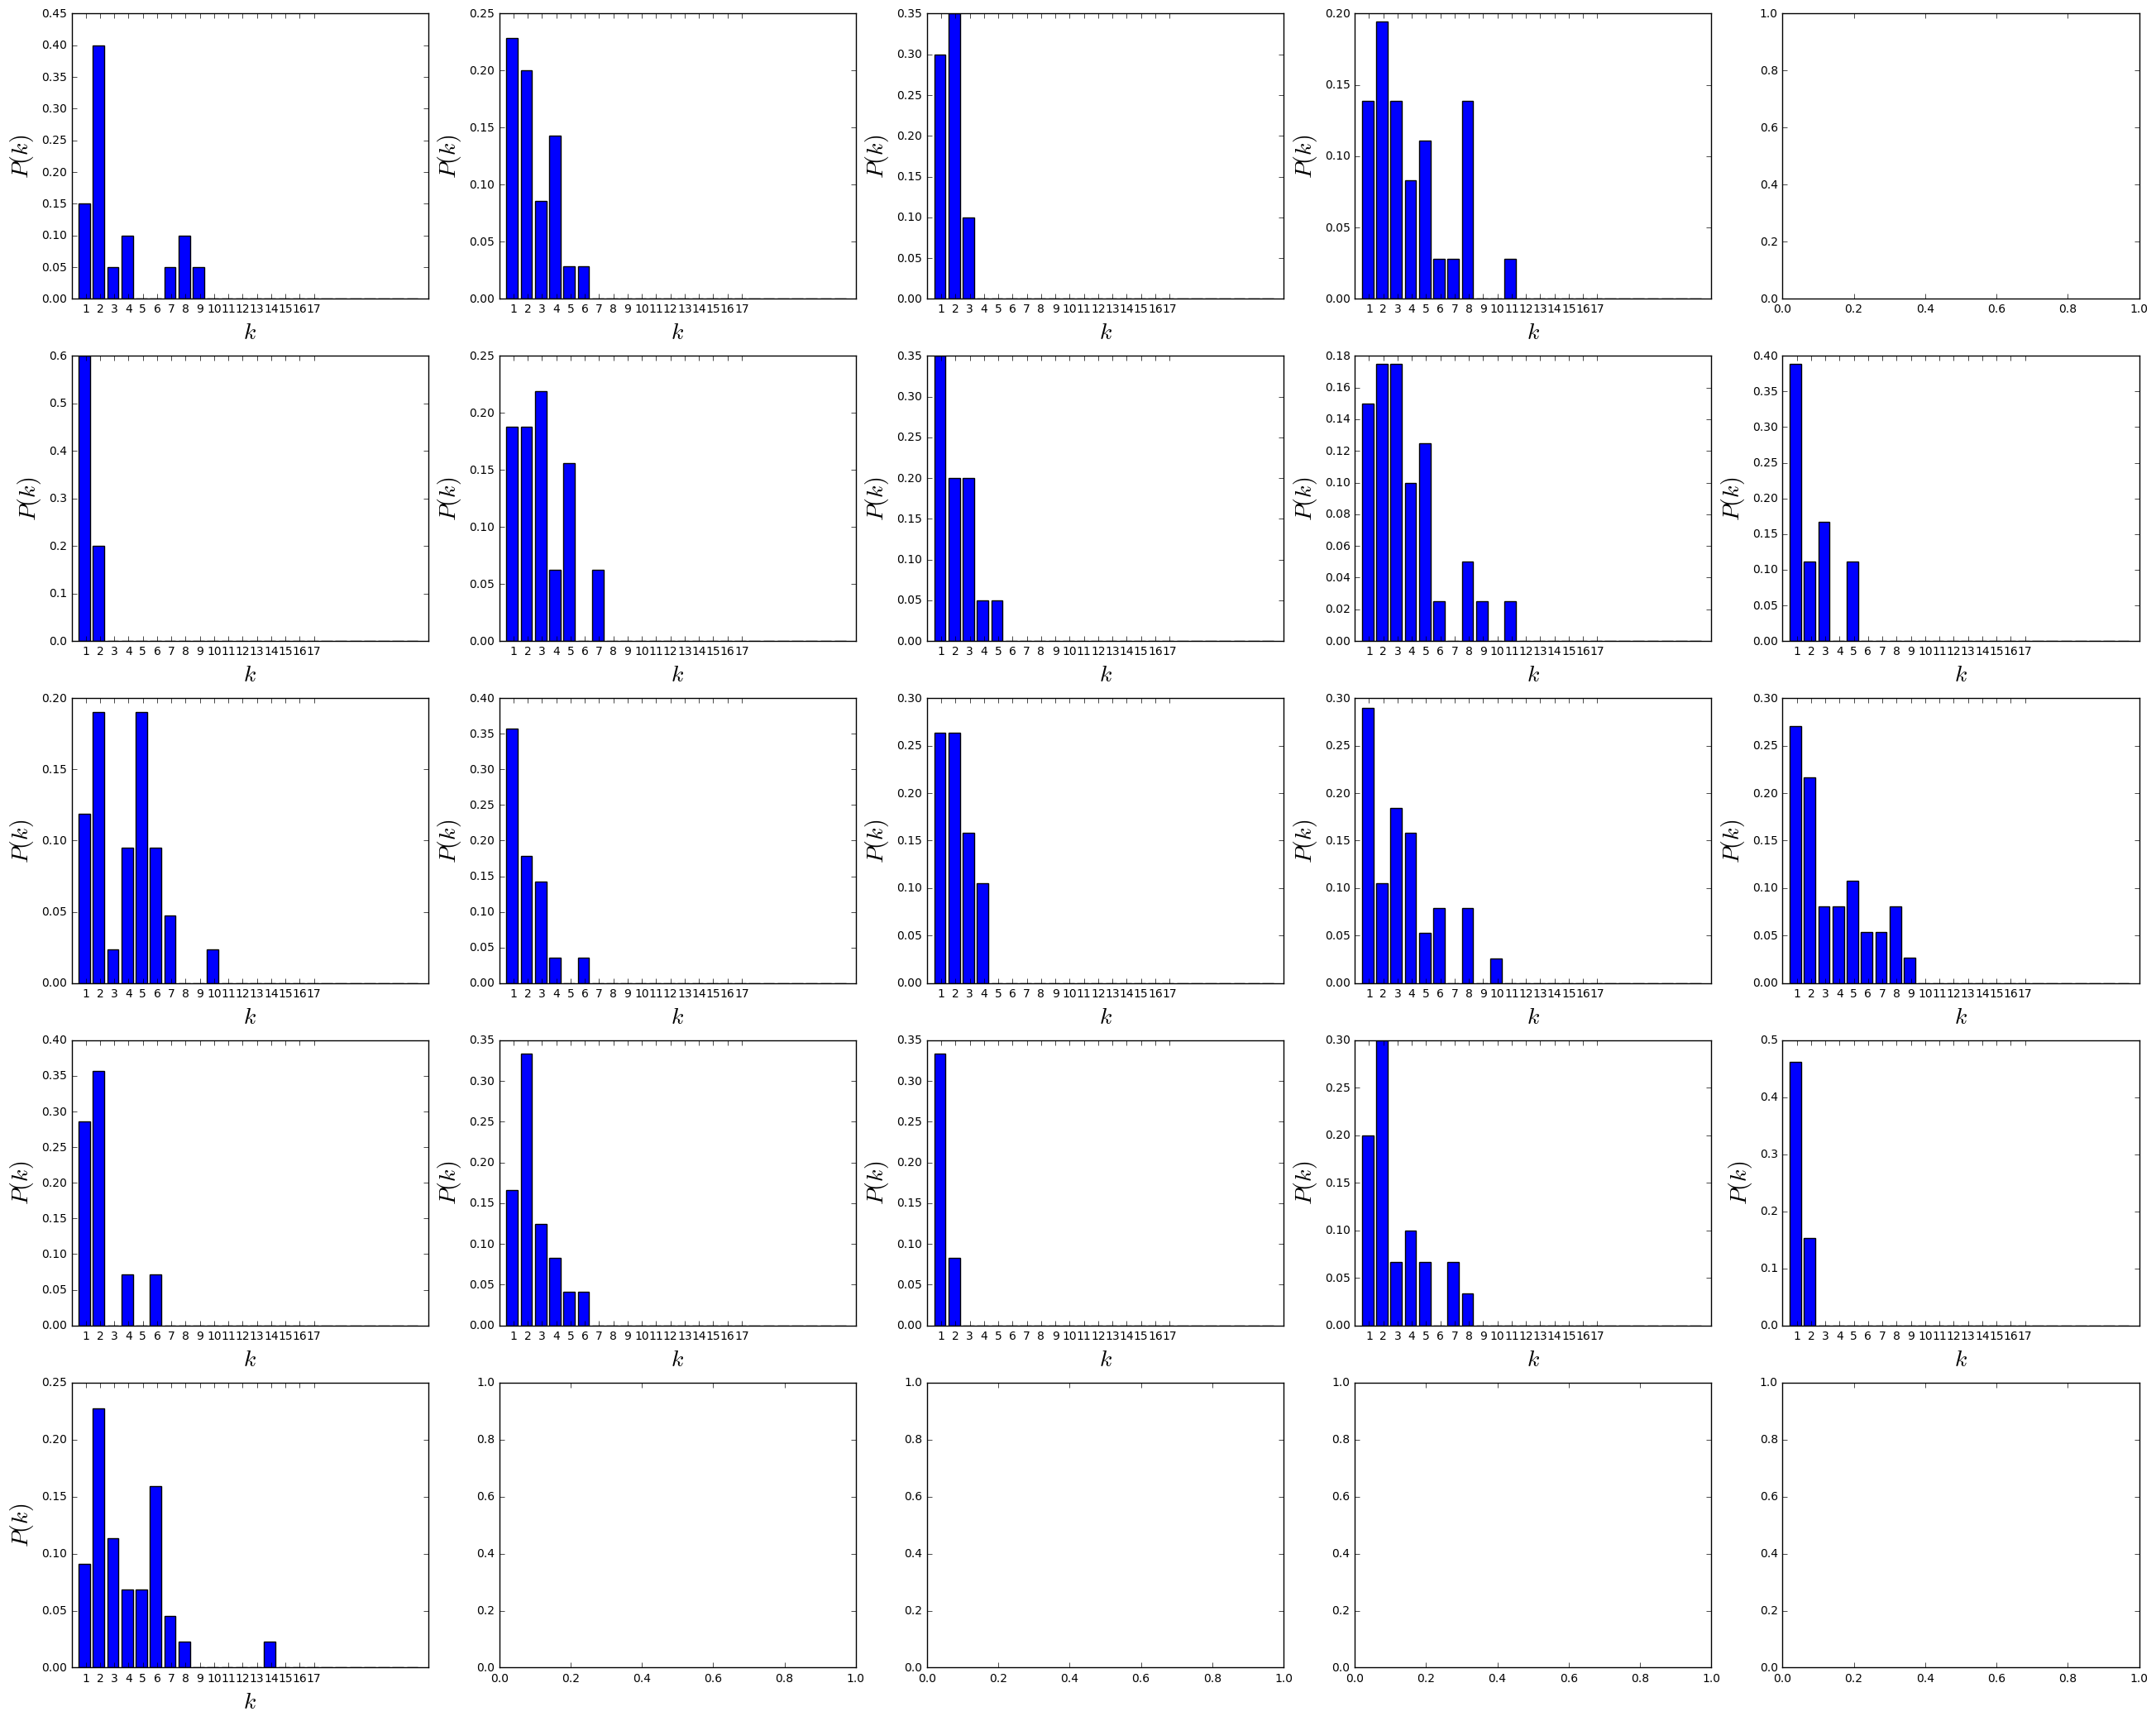

In [61]:
# Visualize the degree distributions for matches
f, axs = plt.subplots(5,5,figsize=(20,20))

# make graphs only have match edges now
for i,_ in enumerate(graphs):
    G = graphs[i]

    edges_to_remove = list()
    for u,v in G.edges():
        if G[u][v]['match'] == 0: 
            edges_to_remove.append( (u,v) )
            
    G.remove_edges_from(edges_to_remove)
            
    if i == 4: continue # skip for drawing purposes

    # graph values
    degree_values=np.array(nx.degree(G).values())
    N=nx.number_of_nodes(G)

    # histogram
    bins=np.arange(0.5,25.5)
    deg_k=np.histogram(degree_values,bins=bins)

    # degree distribution
    P_k=deg_k[0]/np.float(N)

    # plot
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(left=1,bottom=2,right=2.25,top=3) # for axis labels
    plt.bar(bins[:-1],P_k)
    plt.xticks(np.arange(1,18))
    plt.xlabel(r'$k$',fontsize=20)
    plt.ylabel(r'$P(k)$',fontsize=20)

plt.show() # display all the plots

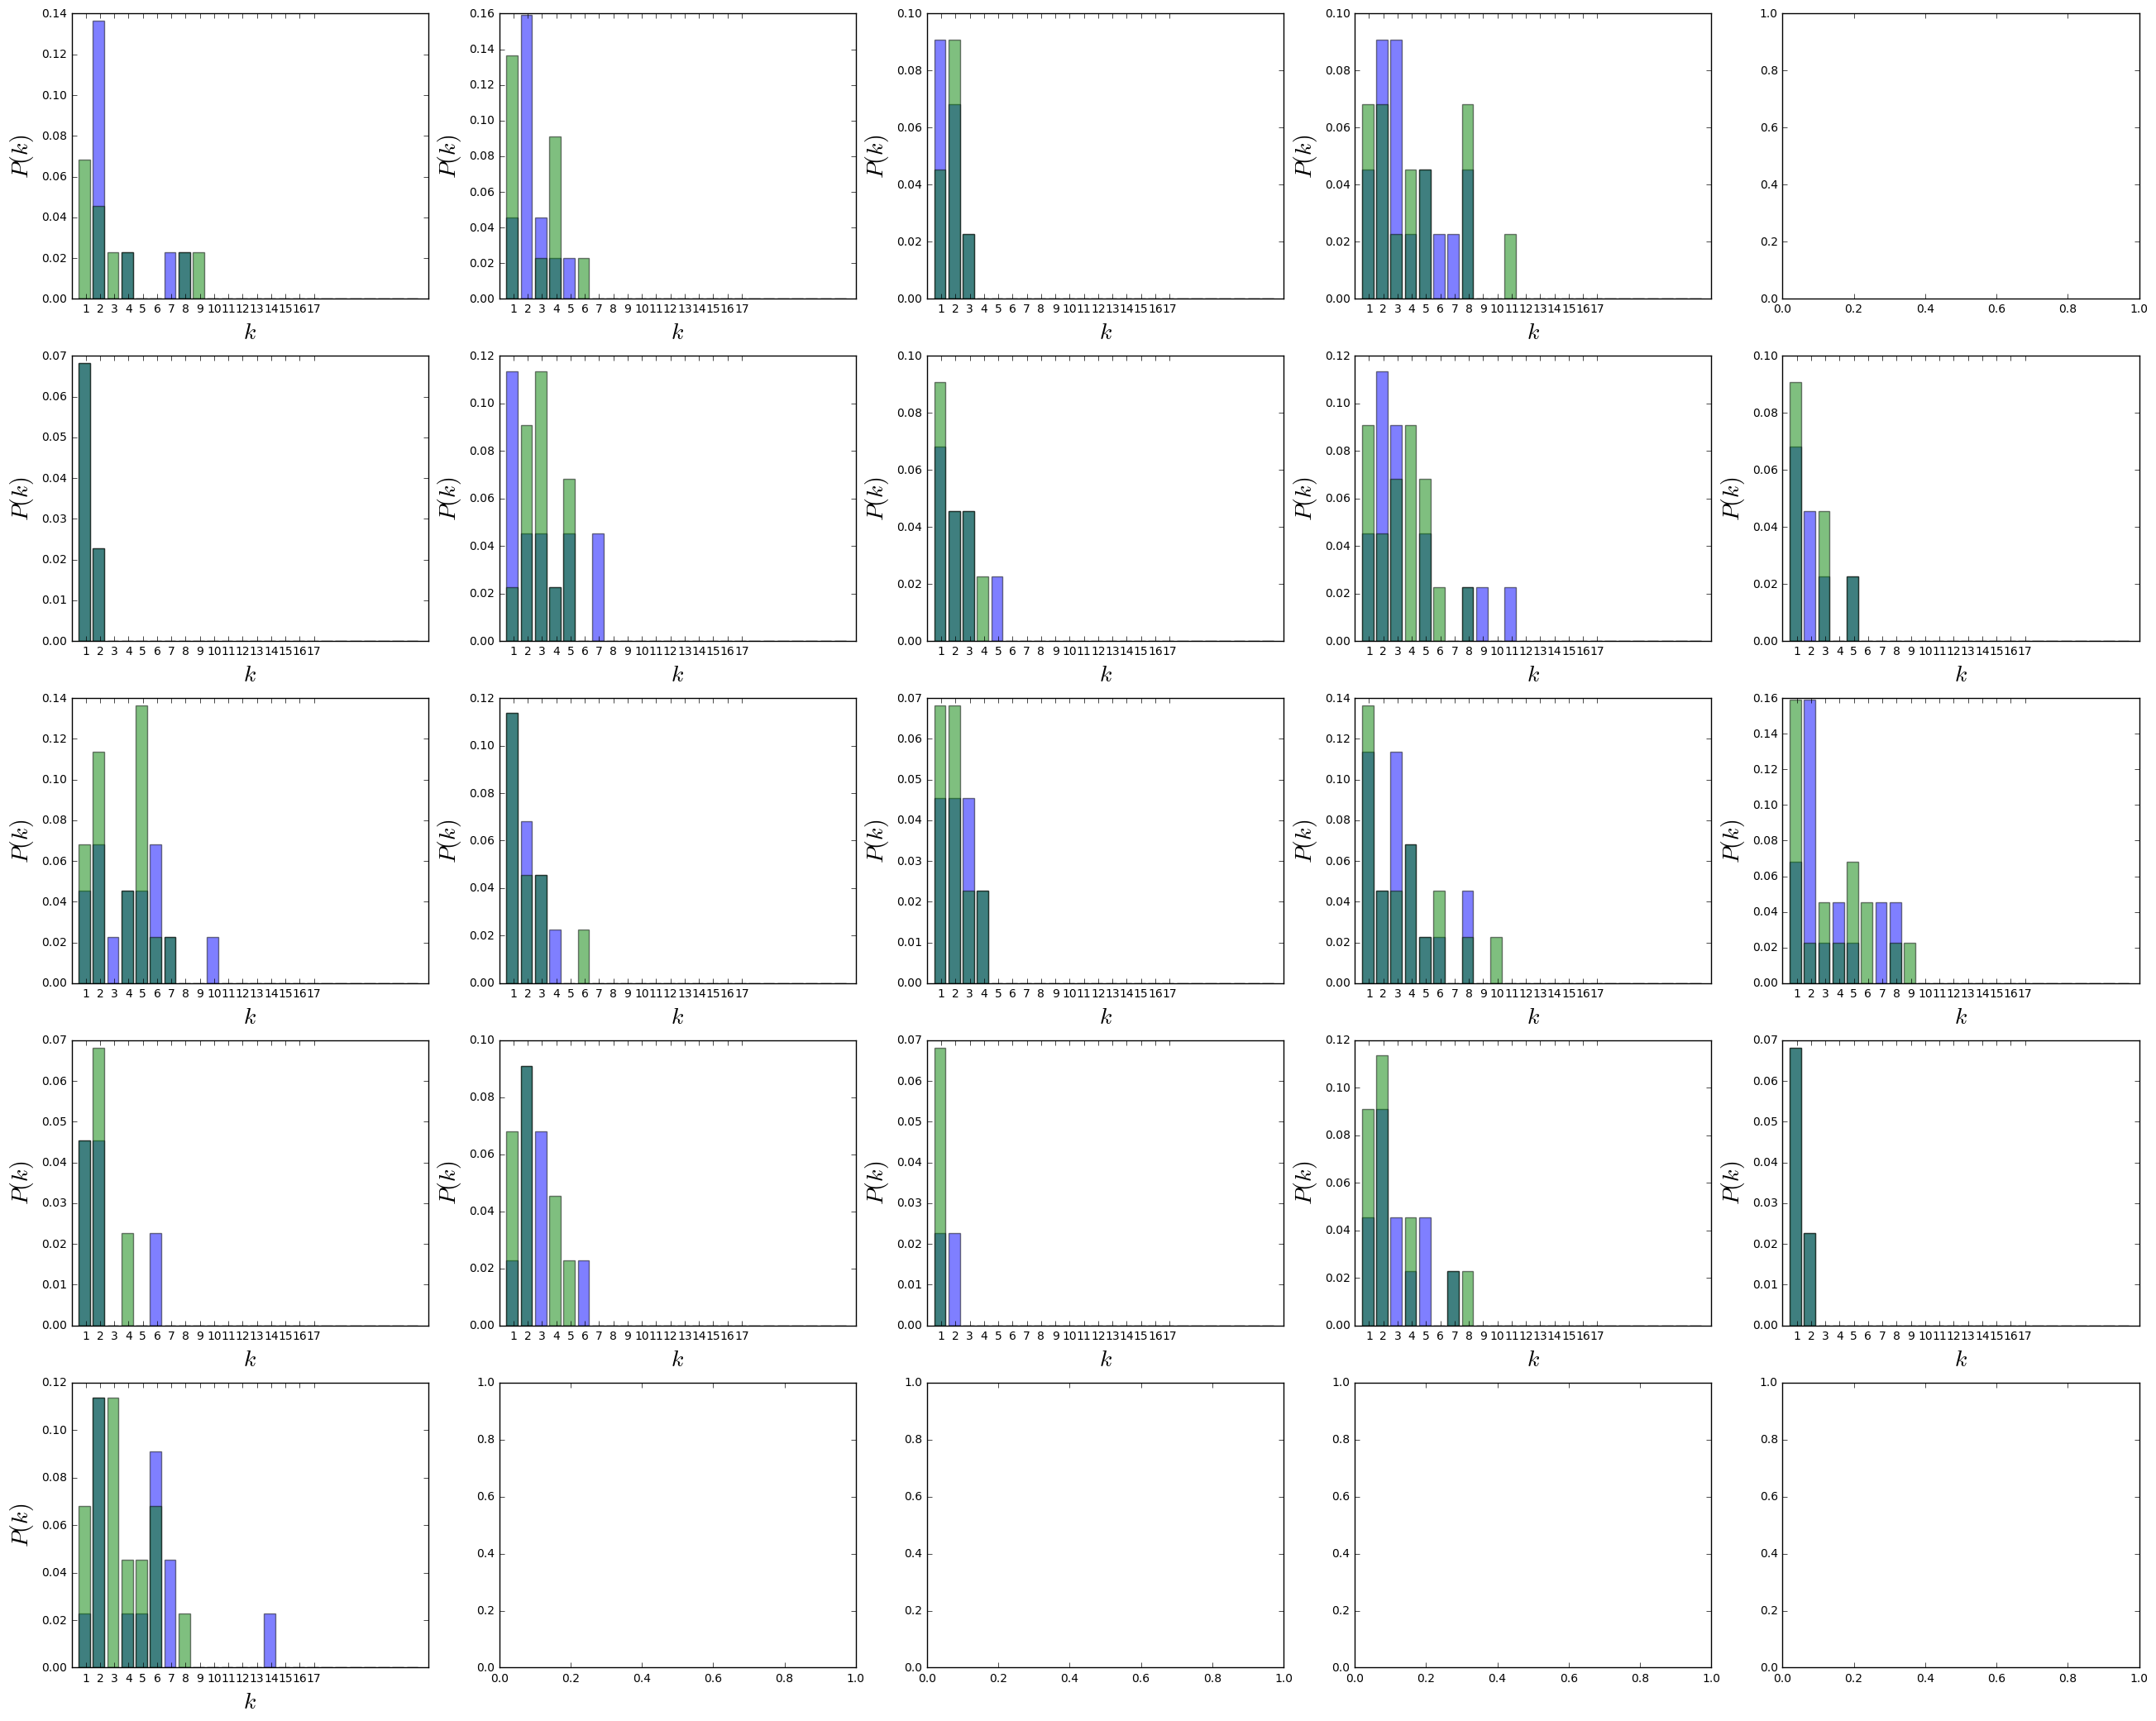

In [60]:
# Visualize the degree distributions for matches by gender
f, axs = plt.subplots(5,5,figsize=(20,20))

# make graphs only have match edges now
for i,_ in enumerate(graphs):
    G = graphs[i]

    edges_to_remove = list()
    for u,v in G.edges():
        if G[u][v]['match'] == 0: 
            edges_to_remove.append( (u,v) )
            
    G.remove_edges_from(edges_to_remove)
            
    if i == 4: continue # skip for drawing purposes
    
    # want to draw distributions by gender
    genders = nx.get_node_attributes(G,'gender')
    males = list(k for k, v in genders.iteritems() if v == 1)
    females = list(k for k, v in genders.iteritems() if v == 0)
    N_male = len(males); N_female = len(females)

    # graph values
    degrees = nx.degree(G); female_degree_values = list(); male_degree_values = list()
    for n,d in degrees.iteritems():
        if n in females: female_degree_values.append(d)
        else: male_degree_values.append(d) # only two options

    # histogram
    bins = np.arange(0.5,25.5)
    deg_k_female = np.histogram(female_degree_values,bins=bins)
    deg_k_male = np.histogram(male_degree_values,bins=bins)

    # degree distribution
    P_k_female = deg_k_female[0]/np.float(N)
    P_k_male = deg_k_male[0]/np.float(N)

    # plot
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(left=1,bottom=2,right=2.25,top=3) # for axis labels
    plt.bar(bins[:-1],P_k_female,color='blue',alpha=0.5)
    plt.bar(bins[:-1],P_k_male,color='green',alpha=0.5)
    plt.xticks(np.arange(1,18))
    plt.xlabel(r'$k$',fontsize=20)
    plt.ylabel(r'$P(k)$',fontsize=20)

plt.show() # display all the plots

In [65]:
# create directed graphs of decisions

# node features of import
node_feat = ['gender', 'field_cd', 'career_c']

# create graphs for each wave
waves = df['wave'].unique()
graphs = list()

# graphs for each wave of matches
for w in waves:
    dta = df.loc[df['wave'] == w]
    # TODO: figure out what other edge attributes to include
    G = nx.from_pandas_dataframe(dta,'iid','pid',edge_attr=['dec','samerace','int_corr'],create_using=nx.DiGraph())
    
    # set node attributes
    # TODO: figure out what other node attributes to include
    for a in node_feat:
        feat = dta[['iid',a]]
        feat = feat.set_index('iid').T.to_dict('records')[0] # convert to dictionary
        nx.set_node_attributes(G,a,feat)
    
    G = nx.convert_node_labels_to_integers(G,first_label=1)
    graphs.append(G)

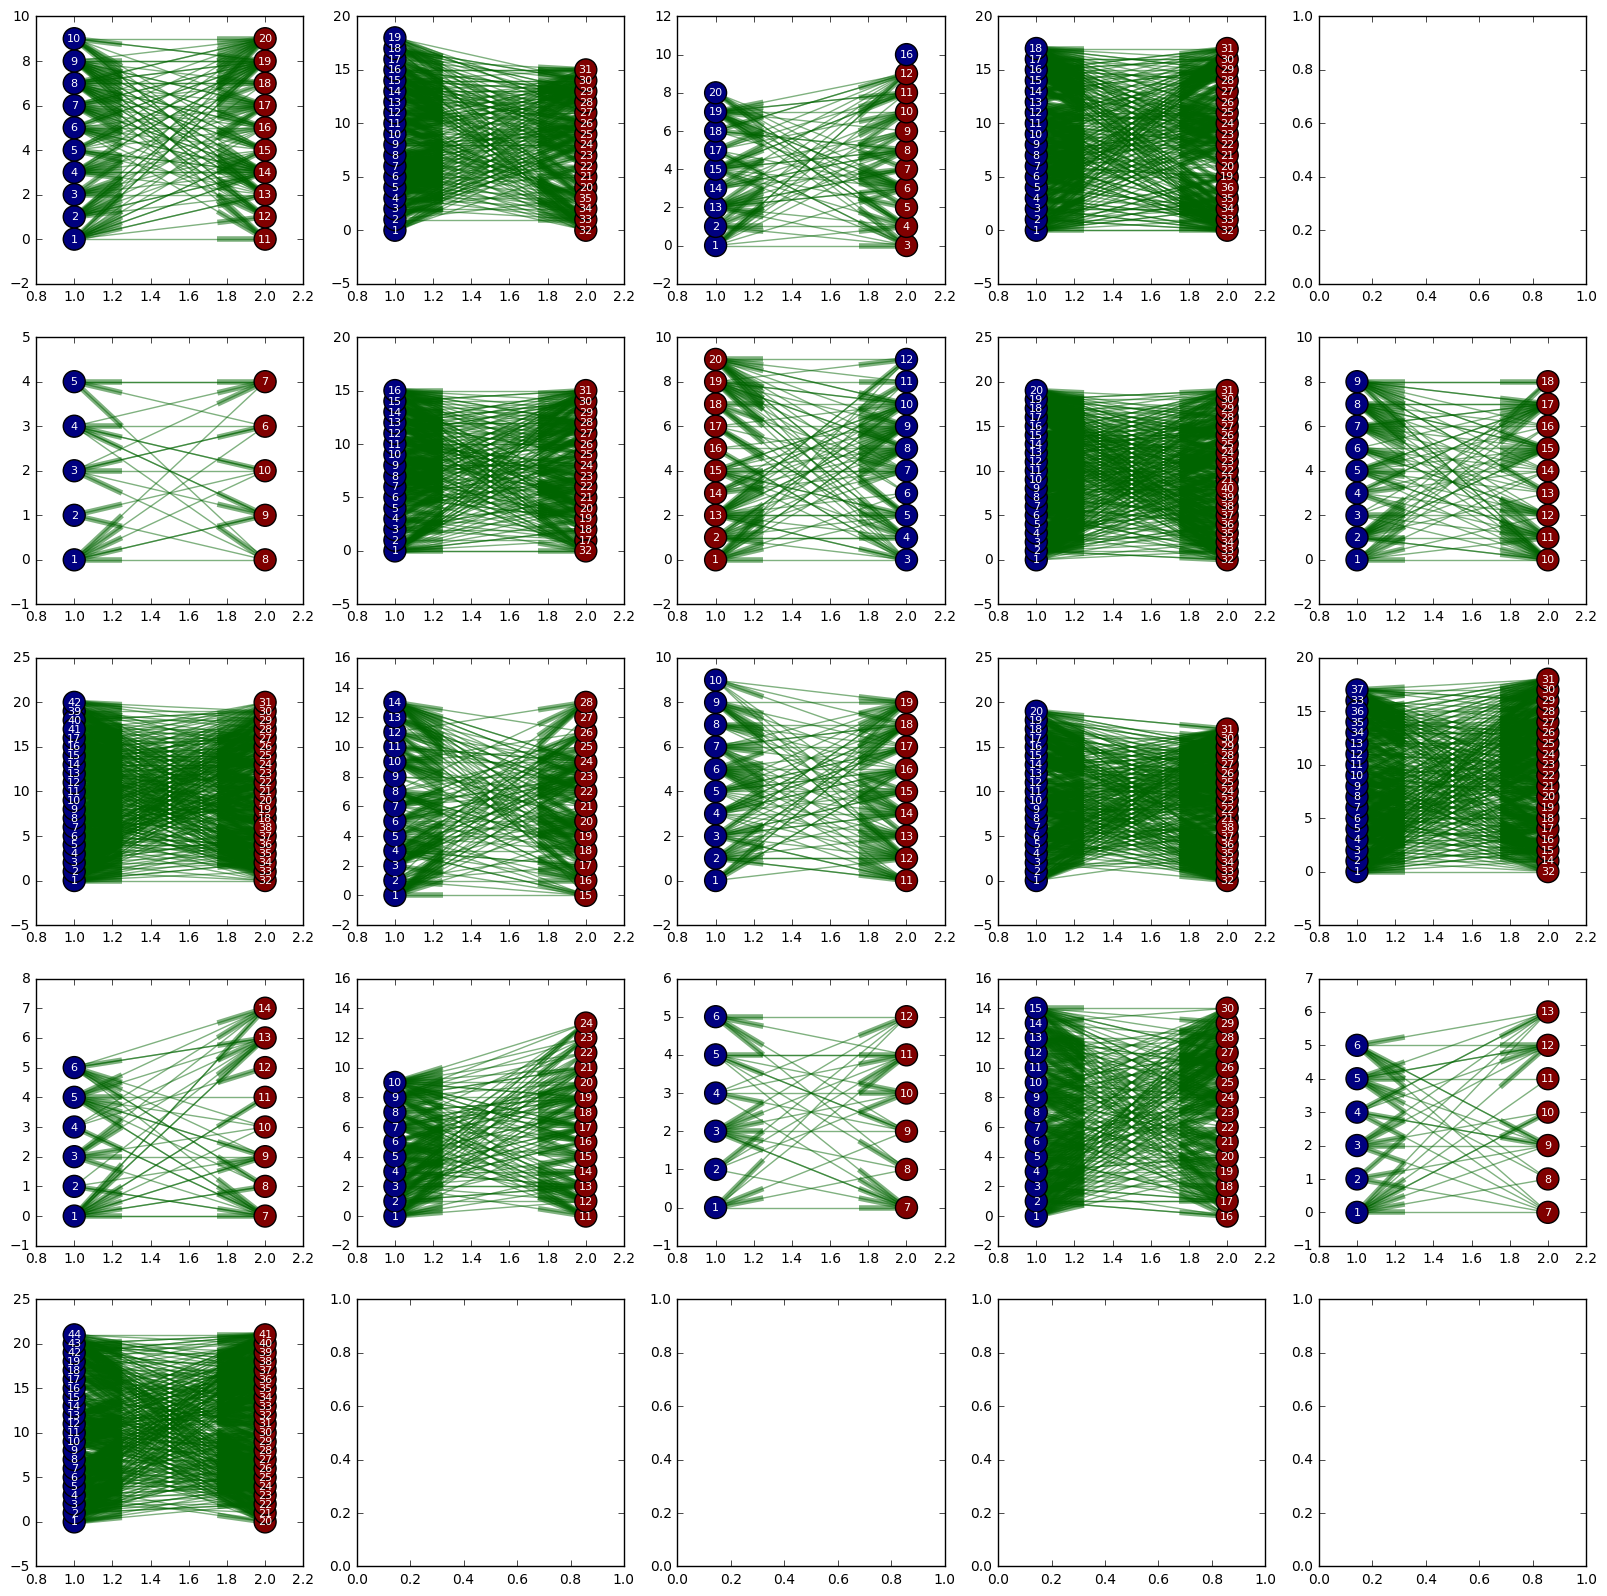

In [69]:
# Visualize the actual networks
f, axs = plt.subplots(5,5,figsize=(20,20))

for i,_ in enumerate(graphs):
    G = graphs[i]
    if i == 4: continue # causing an error bc labels are off in data

    # draw as bipartite graph
    X,Y = bipartite.sets(G)
    pos = dict()
    pos.update( (n, (1, j)) for j, n in enumerate(X) ) # put nodes from X at x=1
    pos.update( (n, (2, j)) for j, n in enumerate(Y) ) # put nodes from Y at x=2

    # draw only edges where the person decided Y
    decisions = list()
    for u,v in G.edges():
        if G[u][v]['dec'] == 1:
            decisions.append( (u,v) )

    # get specified feature for each node
    feats = nx.get_node_attributes(G,'gender').values()

    plt.subplot(5,5,i+1)
    nx.draw_networkx_nodes(G,pos,node_color=feats,node_size=250)
    nx.draw_networkx_labels(G,pos,font_color='white',font_size=8)
    nx.draw_networkx_edges(G,pos,edgelist=decisions,edge_color='darkgreen')
    
plt.show() # display all the plots

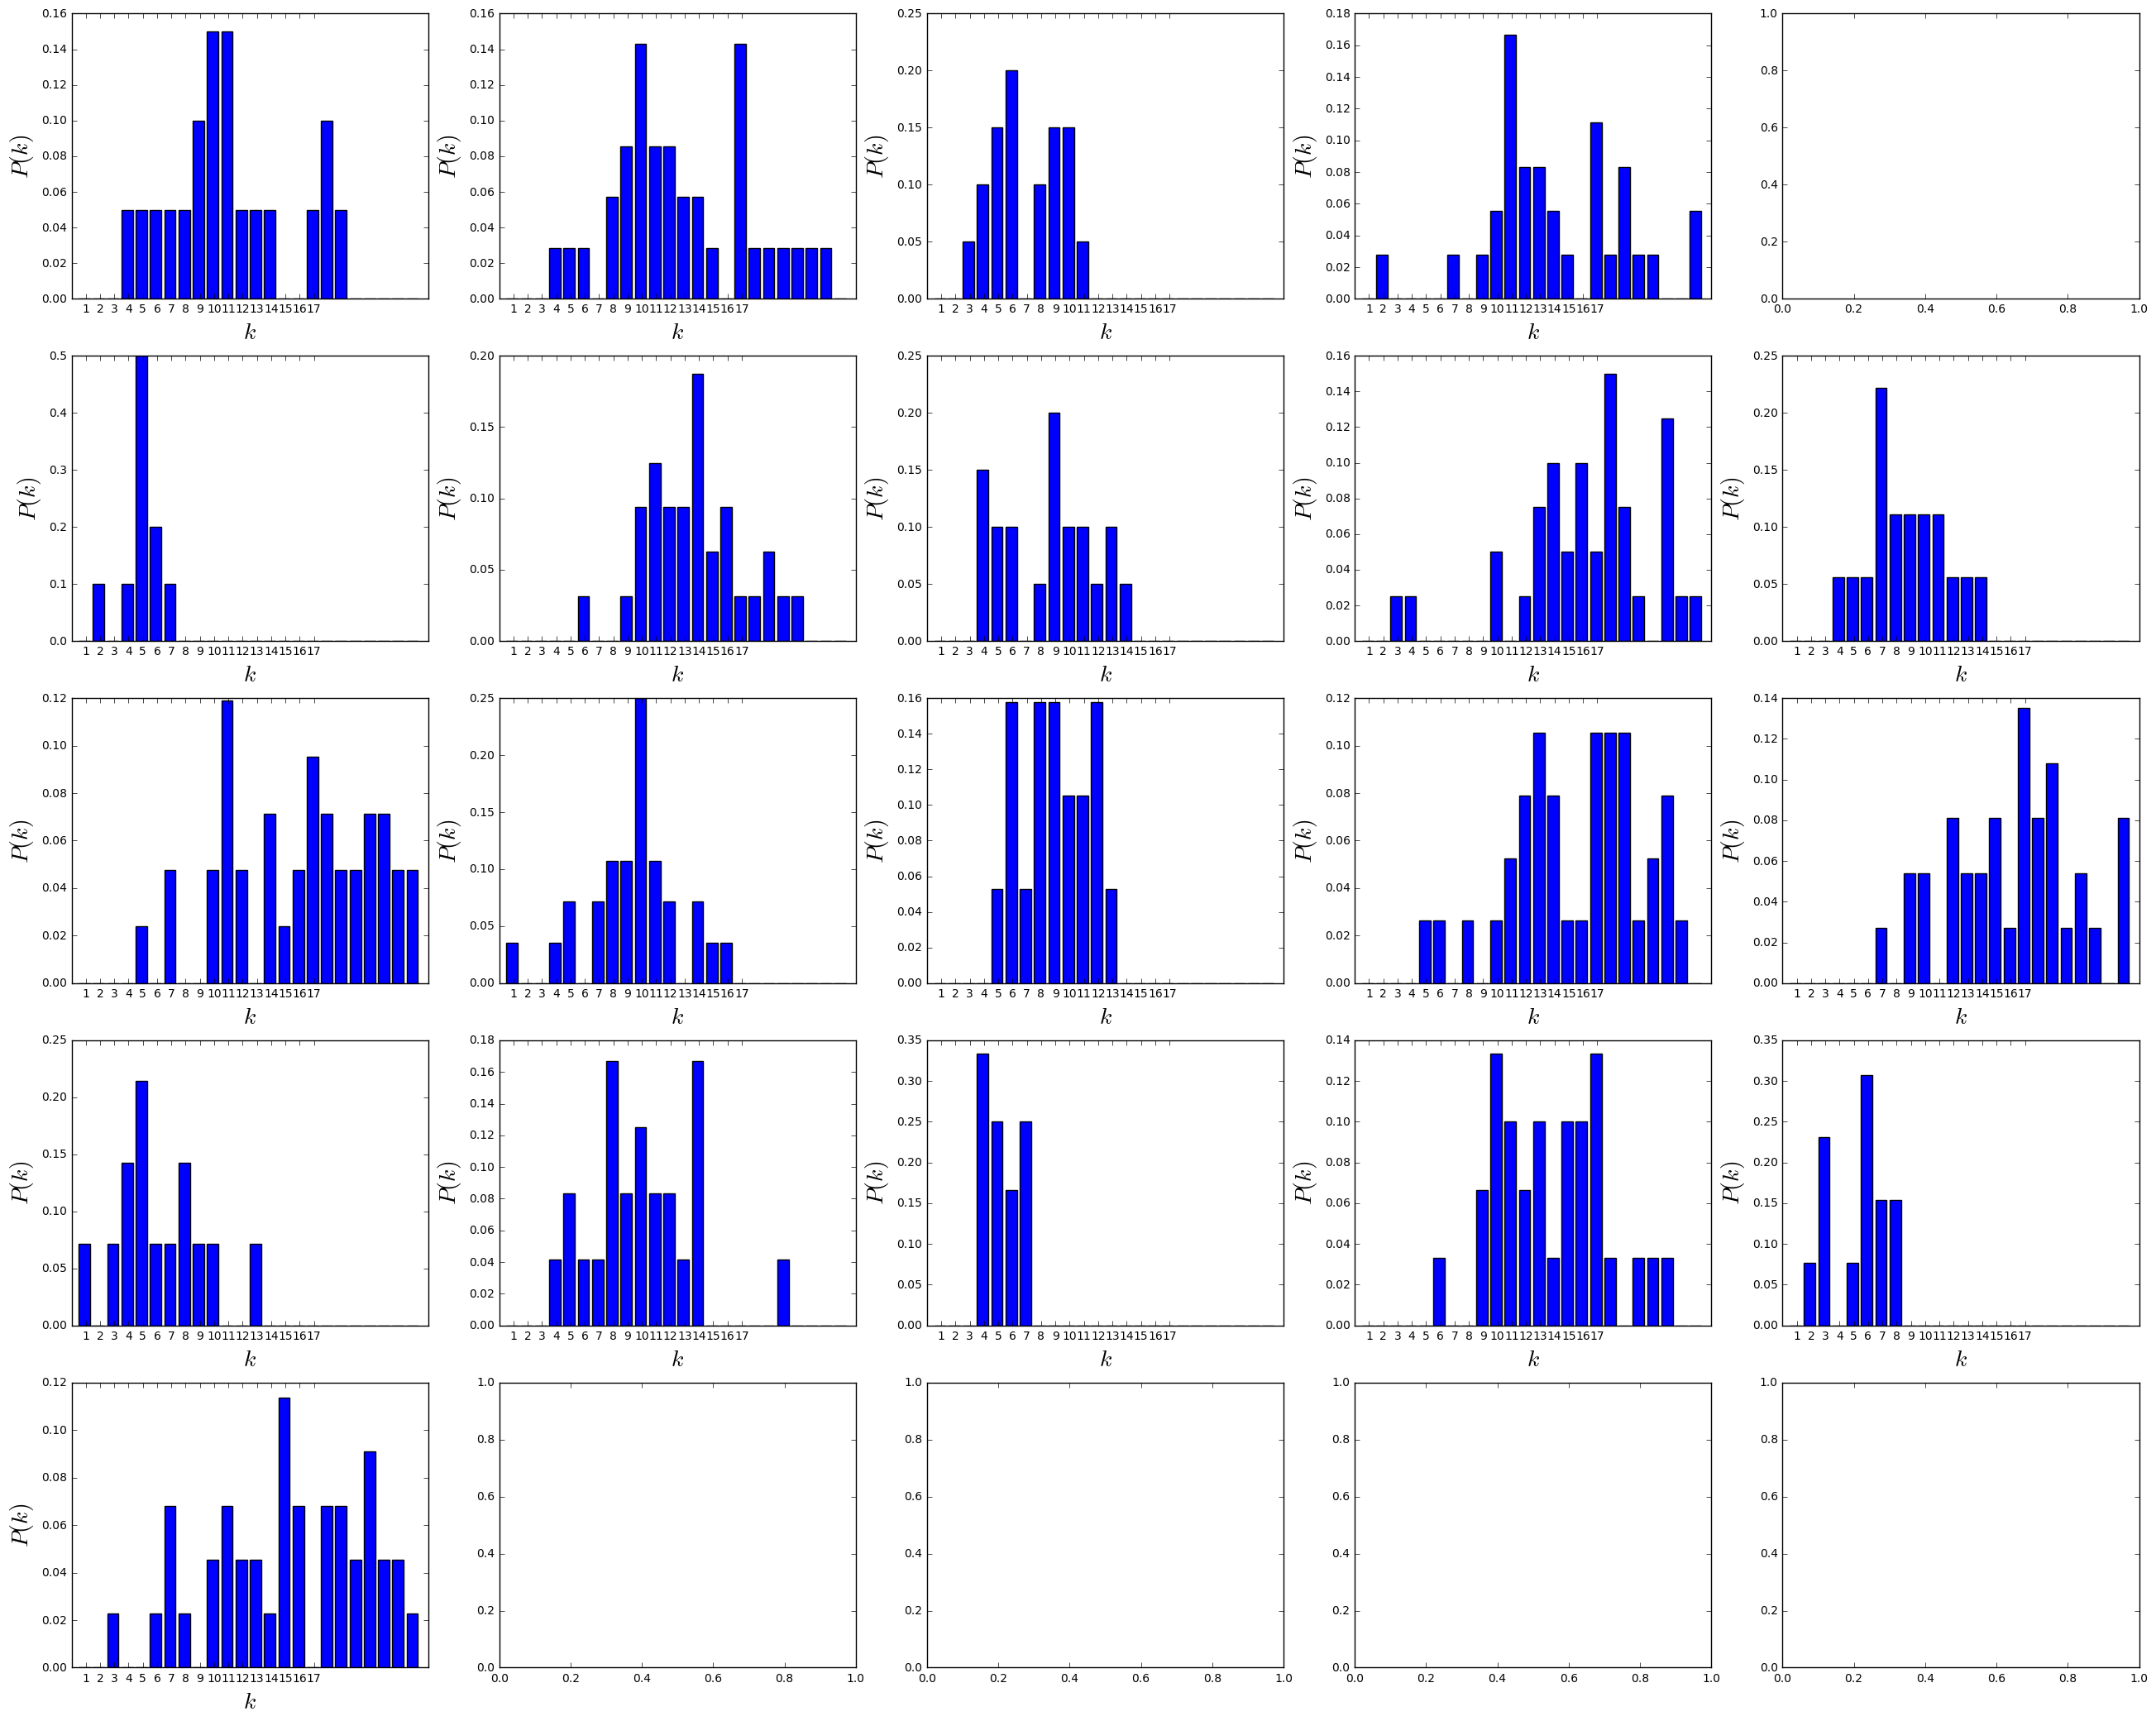

In [67]:
# Visualize the degree distributions
f, axs = plt.subplots(5,5,figsize=(20,20))

# make graphs only have decision edges now
for i,_ in enumerate(graphs):
    G = graphs[i]

    edges_to_remove = list()
    for u,v in G.edges():
        if G[u][v]['dec'] == 0: 
            edges_to_remove.append( (u,v) )
            
    G.remove_edges_from(edges_to_remove)
            
    if i == 4: continue # skip for drawing purposes

    # graph values
    degree_values=np.array(nx.degree(G).values())
    N=nx.number_of_nodes(G)

    # histogram
    bins=np.arange(0.5,25.5)
    deg_k=np.histogram(degree_values,bins=bins)

    # degree distribution
    P_k=deg_k[0]/np.float(N)

    # plot
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(left=1,bottom=2,right=2.25,top=3) # for axis labels
    plt.bar(bins[:-1],P_k)
    plt.xticks(np.arange(1,18))
    plt.xlabel(r'$k$',fontsize=20)
    plt.ylabel(r'$P(k)$',fontsize=20)

plt.show() # display all the plots

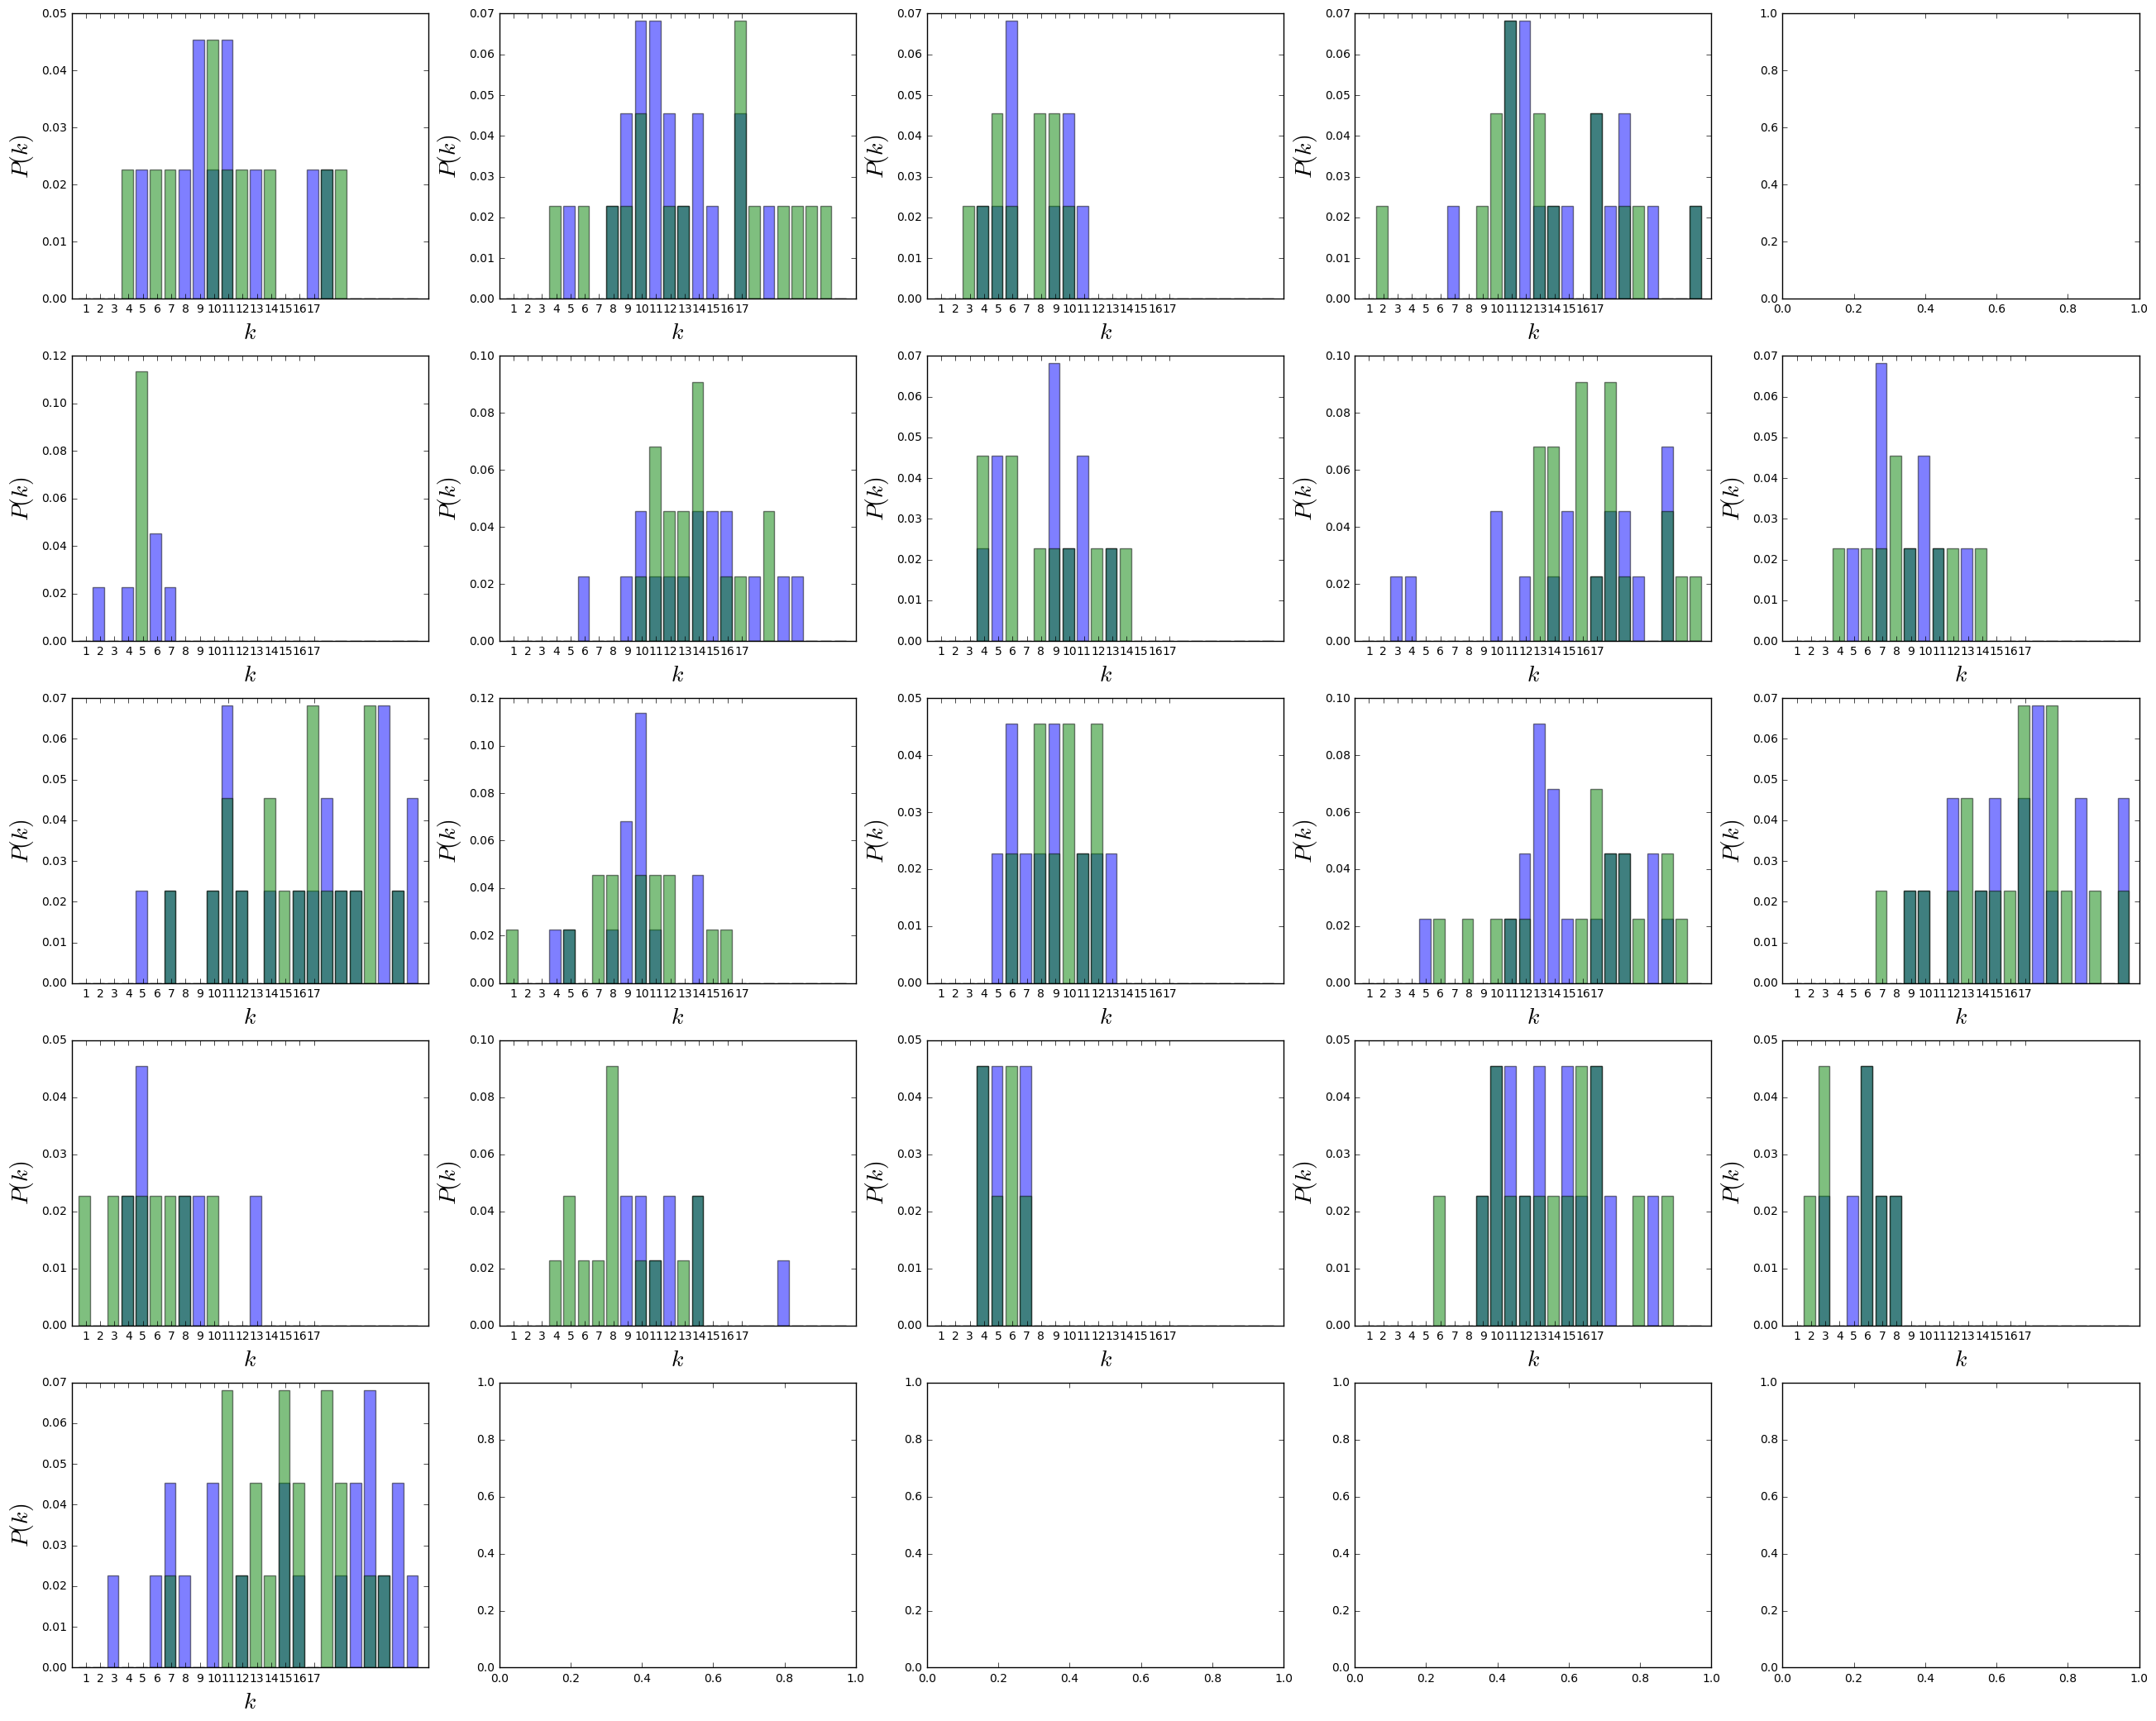

In [68]:
# Visualize the degree distributions for decisions by gender
f, axs = plt.subplots(5,5,figsize=(20,20))

# make graphs only have decision edges now
for i,_ in enumerate(graphs):
    G = graphs[i]

    edges_to_remove = list()
    for u,v in G.edges():
        if G[u][v]['dec'] == 0: 
            edges_to_remove.append( (u,v) )
            
    G.remove_edges_from(edges_to_remove)
            
    if i == 4: continue # skip for drawing purposes
    
    # want to draw distributions by gender
    genders = nx.get_node_attributes(G,'gender')
    males = list(k for k, v in genders.iteritems() if v == 1)
    females = list(k for k, v in genders.iteritems() if v == 0)
    N_male = len(males); N_female = len(females)

    # graph values
    degrees = nx.degree(G); female_degree_values = list(); male_degree_values = list()
    for n,d in degrees.iteritems():
        if n in females: female_degree_values.append(d)
        else: male_degree_values.append(d) # only two options

    # histogram
    bins = np.arange(0.5,25.5)
    deg_k_female = np.histogram(female_degree_values,bins=bins)
    deg_k_male = np.histogram(male_degree_values,bins=bins)

    # degree distribution
    P_k_female = deg_k_female[0]/np.float(N)
    P_k_male = deg_k_male[0]/np.float(N)

    # plot
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(left=1,bottom=2,right=2.25,top=3) # for axis labels
    plt.bar(bins[:-1],P_k_female,color='blue',alpha=0.5)
    plt.bar(bins[:-1],P_k_male,color='green',alpha=0.5)
    plt.xticks(np.arange(1,18))
    plt.xlabel(r'$k$',fontsize=20)
    plt.ylabel(r'$P(k)$',fontsize=20)

plt.show() # display all the plots

In [114]:
# Generate networks connecting participants to categorical variables
# potential categorical variables of interest: wave, field/field_cd, undergrad/mn_sat/tuition, race,
#   from/zipcode/income, career/career_c, 
# TODO: update and explore the above list

# create graphs for each from
fields = df['field'].unique()
graphs = list()

# graphs for each from
for f in fields:
    dta = df.loc[df['field'] == f]
    G = nx.from_pandas_dataframe(dta,'iid','field')
    
    #G = nx.convert_node_labels_to_integers(G,first_label=1)
    graphs.append(G)

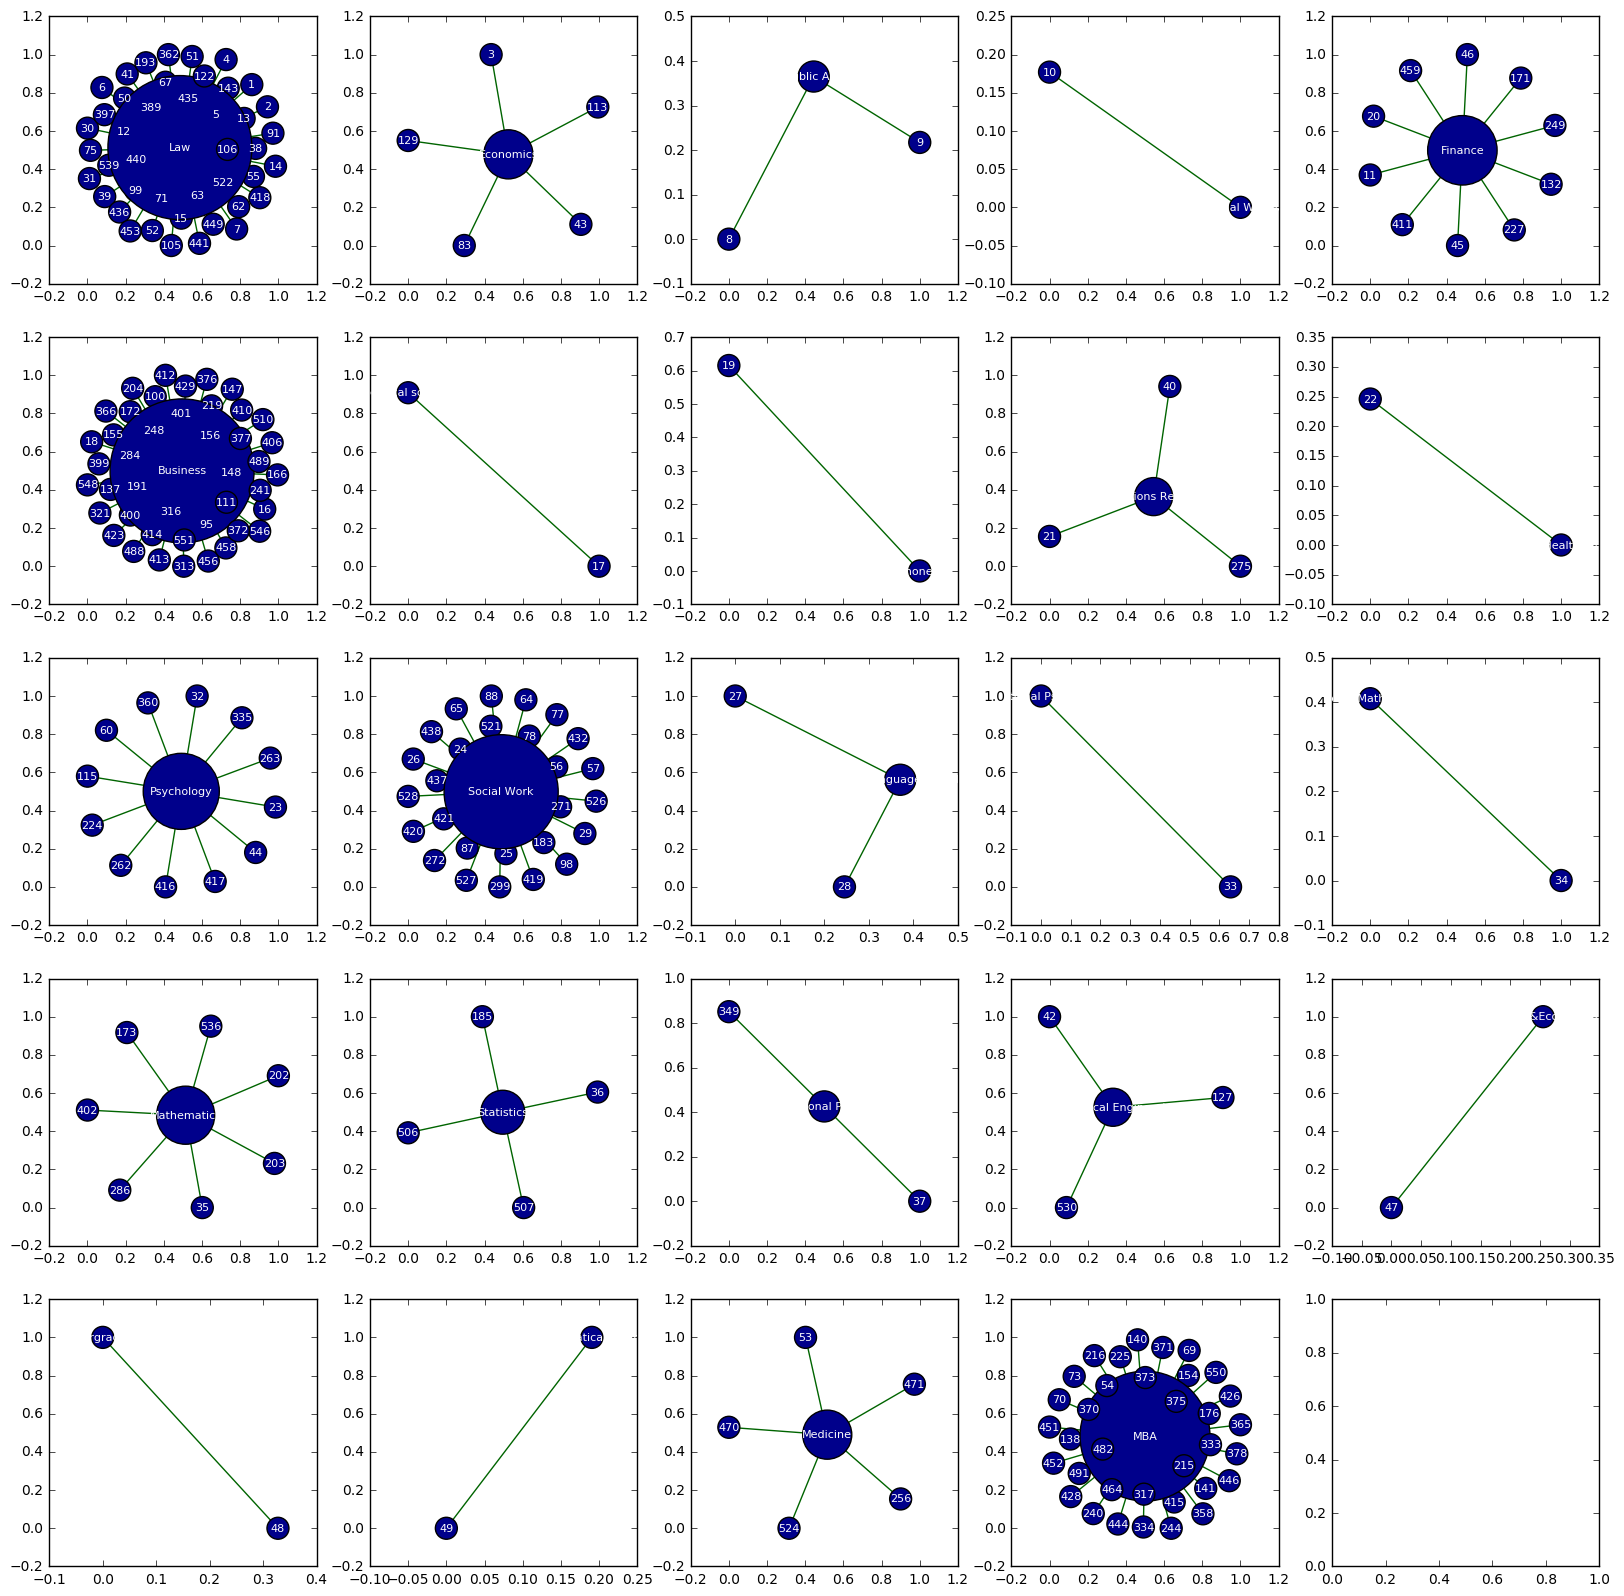

In [116]:
# Visualize the actual networks
f, axs = plt.subplots(5,5,figsize=(20,20))

for i,_ in enumerate(graphs[0:24]):
    G = graphs[i]
    
    # in order to map degrees to nodes correctly
    node_list,node_sizes = zip(*nx.degree(G).items())
    node_sizes = np.array(node_sizes)
    
    plt.subplot(5,5,i+1)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color='darkblue',node_size=250*node_sizes,nodelist=node_list)
    nx.draw_networkx_labels(G,pos,font_color='white',font_size=8)
    nx.draw_networkx_edges(G,pos,edge_color='darkgreen')
    
plt.show() # display all the plots